# Check we can read the file

In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib as mpl
import matplotlib.pyplot as plt
import calendar
import datetime as dt
from scipy.stats import norm
from scipy import stats
import statistics
import os

#plt.style.use('dark_background')
plt.rcParams['figure.figsize'] = [10, 5]

print("Looking for data here: ", os.getcwd())

data = pd.read_csv('dataset.csv', encoding='ISO-8859–1')
df = pd.DataFrame(data)
print("Number of rows & columns: ", df.shape)

Looking for data here:  /home/henry/Data/Kickstarter
Number of rows & columns:  (45957, 17)


# Let's fix the columns so they're easier to access

In [2]:
# remove spaces in column names
df.columns = df.columns.str.replace(' ', '_')

# A little function to help us later

In [3]:
def is_outlier(points, thresh=3.5):
    """
    Returns a boolean array with True if points are outliers and False 
    otherwise.

    Parameters:
    -----------
        points : An numobservations by numdimensions array of observations
        thresh : The modified z-score to use as a threshold. Observations with
            a modified z-score (based on the median absolute deviation) greater
            than this value will be classified as outliers.

    Returns:
    --------
        mask : A numobservations-length boolean array.

    References:
    ----------
        Boris Iglewicz and David Hoaglin (1993), "Volume 16: How to Detect and
        Handle Outliers", The ASQC Basic References in Quality Control:
        Statistical Techniques, Edward F. Mykytka, Ph.D., Editor. 
    """
    if len(points.shape) == 1:
        points = points[:,None]
    median = np.median(points, axis=0)
    diff = np.sum((points - median)**2, axis=-1)
    diff = np.sqrt(diff)
    med_abs_deviation = np.median(diff)

    modified_z_score = 0.6745 * diff / med_abs_deviation

    return modified_z_score > thresh

# Preview the data

In [4]:
df.head(10)

,project_id,name,url,category,subcategory,location,status,goal,pledged,funded_percentage,backers,funded_date,levels,reward_levels,updates,comments,duration
0,39409,WHILE THE TREES SLEEP,http://www.kickstarter.com/projects/emiliesaba...,Film & Video,Short Film,"Columbia, MO",successful,10500.0,11545.0,1.099524,66,"Fri, 19 Aug 2011 19:28:17 -0000",7,"$25,$50,$100,$250,$500,$1,000,$2,500",10,2,30.00
1,126581,Educational Online Trading Card Game,http://www.kickstarter.com/projects/972789543/...,Games,Board & Card Games,"Maplewood, NJ",failed,4000.0,20.0,0.005000,2,"Mon, 02 Aug 2010 03:59:00 -0000",5,"$1,$5,$10,$25,$50",6,0,47.18
2,138119,STRUM,http://www.kickstarter.com/projects/185476022/...,Film & Video,Animation,"Los Angeles, CA",live,20000.0,56.0,0.002800,3,"Fri, 08 Jun 2012 00:00:31 -0000",10,"$1,$10,$25,$40,$50,$100,$250,$1,000,$1,337,$9,001",1,0,28.00
3,237090,GETTING OVER - One son's search to finally kno...,http://www.kickstarter.com/projects/charnick/g...,Film & Video,Documentary,"Los Angeles, CA",successful,6000.0,6535.0,1.089167,100,"Sun, 08 Apr 2012 02:14:00 -0000",13,"$1,$10,$25,$30,$50,$75,$85,$100,$110,$250,$500...",4,0,32.22
4,246101,The Launch of FlyeGrlRoyalty &quot;The New Nam...,http://www.kickstarter.com/projects/flyegrlroy...,Fashion,Fashion,"Novi, MI",failed,3500.0,0.0,0.000000,0,"Wed, 01 Jun 2011 15:25:39 -0000",6,"$10,$25,$50,$100,$150,$250",2,0,30.00
5,316217,Dinner Party - a short film about friendship.....,http://www.kickstarter.com/projects/249354515/...,Film & Video,Short Film,"Portland, OR",successful,3500.0,3582.0,1.023331,39,"Wed, 22 Jun 2011 13:33:00 -0000",7,"$5,$25,$50,$100,$250,$500,$1,000",8,0,21.43
6,325034,Mezzo,http://www.kickstarter.com/projects/geoffsaysh...,Film & Video,Short Film,"Collegedale, TN",failed,1000.0,280.0,0.280000,8,"Sat, 18 Feb 2012 02:17:08 -0000",5,"$5,$10,$25,$50,$100",0,0,30.00
7,407836,Help APORTA continue to make handwoven/knit ac...,http://www.kickstarter.com/projects/1078097864...,Fashion,Fashion,"Chicago, IL",successful,2000.0,2180.0,1.090000,46,"Fri, 30 Dec 2011 04:36:53 -0000",7,"$10,$20,$50,$100,$250,$500,$1,000",13,5,30.00
8,436325,Music - Comedy - Album!,http://www.kickstarter.com/projects/mattgriffo...,Music,Music,"Chicago, IL",successful,1000.0,1125.0,1.125000,30,"Sun, 18 Apr 2010 04:59:00 -0000",12,"$5,$8,$10,$15,$20,$30,$50,$100,$120,$250,$500,...",10,1,67.53
9,610918,The Apocalypse Calendar,http://www.kickstarter.com/projects/tqvinn/the...,Art,Illustration,"Chicago, IL",successful,7500.0,9836.0,1.311527,255,"Tue, 01 Nov 2011 04:59:00 -0000",10,"$1,$20,$35,$50,$60,$100,$110,$500,$1,000,$1,500",6,5,35.29


# Are there any duplicate rows? If so, let's get rid of them

In [5]:
df.duplicated().sum()

89

In [6]:
(~df.duplicated()).sum()

45868

In [7]:
df.loc[data.duplicated(), :]  # this defaults to dropping all but the first example, which is what we want

,project_id,name,url,category,subcategory,location,status,goal,pledged,funded_percentage,backers,funded_date,levels,reward_levels,updates,comments,duration
45652,2140333236,Imagined Family Heirlooms: An Archive of Inher...,http://www.kickstarter.com/projects/andersonst...,Photography,Photography,"Little Rock, AR",successful,5800.0,8521.0,1.469138,110,"Fri, 29 Jul 2011 00:53:53 -0000",16,"$10,$20,$35,$50,$75,$100,$150,$200,$225,$300,$...",5,4,67.00
45654,2140344109,Help Fund Thana Alexa's Debut Album &quot;Ode ...,http://www.kickstarter.com/projects/1024906052...,Music,Jazz,"New York, NY",successful,15000.0,16678.0,1.111867,142,"Sun, 20 May 2012 20:36:57 -0000",16,"$1,$5,$10,$15,$25,$50,$75,$100,$200,$250,$300,...",5,2,32.00
45656,2140513451,The Cookie Chew - Changing the Way We Eat a Co...,http://www.kickstarter.com/projects/1650956569...,Food,Food,"San Diego, CA",successful,4500.0,5540.0,1.231111,89,"Tue, 24 Aug 2010 04:43:00 -0000",5,"$10,$50,$75,$100,$500",14,17,43.27
45658,2140547791,Ant Invasion iPhone Game App,http://www.kickstarter.com/projects/antinvasio...,Games,Video Games,"Burlington, NJ",failed,5000.0,0.0,0.000000,0,"Mon, 19 Sep 2011 19:08:43 -0000",7,"$1,$5,$10,$20,$50,$100,$500",1,0,45.00
45662,2140580673,12 for '12 (2.0): Shotguns &amp; Sorcery Novels,http://www.kickstarter.com/projects/forbeck/12...,Publishing,Fiction,"Beloit, WI",successful,3000.0,12800.0,4.266770,332,"Mon, 12 Mar 2012 04:59:00 -0000",12,"$5,$25,$35,$50,$70,$100,$125,$250,$500,$1,000,...",19,18,26.56
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
45916,2145979243,Recycled Socks Made on an Antique Auto-Knittin...,http://www.kickstarter.com/projects/393751172/...,Design,Crafts,"Seattle, WA",successful,1500.0,1630.0,1.086667,34,"Thu, 03 Nov 2011 23:38:29 -0000",5,"$1,$20,$25,$50,$100",6,7,30.00
45920,2146152736,George Romero in Zombie Squash Game,http://www.kickstarter.com/projects/1854966399...,Games,Video Games,"Phoenix, AZ",live,7500.0,820.0,0.109333,9,"Fri, 22 Jun 2012 07:03:26 -0000",19,"$1,$2,$5,$10,$15,$25,$30,$30,$30,$40,$50,$50,$...",2,0,30.00
45924,2146182217,I Love You Like A Monkey,http://www.kickstarter.com/projects/971791040/...,Publishing,Children's Book,"Long Island, NY",live,1200.0,47.0,0.039167,5,"Mon, 18 Jun 2012 04:01:11 -0000",9,"$1,$5,$10,$25,$50,$75,$100,$150,$250",0,0,30.00
45930,2146435917,Making Mama(s) Proud: The 2011 &quot;Donna/Mad...,http://www.kickstarter.com/projects/johnpaulka...,Theater,Theater,"Los Angeles, CA",successful,5000.0,5390.0,1.078000,86,"Sat, 04 Jun 2011 08:56:58 -0000",8,"$1,$10,$25,$50,$100,$200,$500,$1,000",5,1,30.00


In [8]:
df.drop_duplicates()

,project_id,name,url,category,subcategory,location,status,goal,pledged,funded_percentage,backers,funded_date,levels,reward_levels,updates,comments,duration
0,39409,WHILE THE TREES SLEEP,http://www.kickstarter.com/projects/emiliesaba...,Film & Video,Short Film,"Columbia, MO",successful,10500.0,11545.0,1.099524,66,"Fri, 19 Aug 2011 19:28:17 -0000",7,"$25,$50,$100,$250,$500,$1,000,$2,500",10,2,30.00
1,126581,Educational Online Trading Card Game,http://www.kickstarter.com/projects/972789543/...,Games,Board & Card Games,"Maplewood, NJ",failed,4000.0,20.0,0.005000,2,"Mon, 02 Aug 2010 03:59:00 -0000",5,"$1,$5,$10,$25,$50",6,0,47.18
2,138119,STRUM,http://www.kickstarter.com/projects/185476022/...,Film & Video,Animation,"Los Angeles, CA",live,20000.0,56.0,0.002800,3,"Fri, 08 Jun 2012 00:00:31 -0000",10,"$1,$10,$25,$40,$50,$100,$250,$1,000,$1,337,$9,001",1,0,28.00
3,237090,GETTING OVER - One son's search to finally kno...,http://www.kickstarter.com/projects/charnick/g...,Film & Video,Documentary,"Los Angeles, CA",successful,6000.0,6535.0,1.089167,100,"Sun, 08 Apr 2012 02:14:00 -0000",13,"$1,$10,$25,$30,$50,$75,$85,$100,$110,$250,$500...",4,0,32.22
4,246101,The Launch of FlyeGrlRoyalty &quot;The New Nam...,http://www.kickstarter.com/projects/flyegrlroy...,Fashion,Fashion,"Novi, MI",failed,3500.0,0.0,0.000000,0,"Wed, 01 Jun 2011 15:25:39 -0000",6,"$10,$25,$50,$100,$150,$250",2,0,30.00
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
45952,2147336747,The Dance Project,http://www.kickstarter.com/projects/685772205/...,Dance,Dance,"Austin, TX",successful,500.0,601.0,1.202000,13,"Fri, 30 Mar 2012 13:57:00 -0000",3,"$20,$50,$100",2,0,37.83
45953,2147346811,new album from J-Sw!ft The Adventures of Negro...,http://www.kickstarter.com/projects/170926480/...,Music,Hip-Hop,"Los Angeles, CA",failed,10000.0,75.0,0.007500,2,"Sun, 22 Apr 2012 02:12:10 -0000",14,"$1,$5,$10,$25,$50,$50,$75,$100,$200,$250,$500,...",1,1,59.96
45954,2147367534,ELIZABETH REX,http://www.kickstarter.com/projects/elizabethr...,Music,Rock,"Los Angeles, CA",successful,10000.0,10000.0,1.000000,58,"Mon, 16 Jan 2012 05:00:00 -0000",4,"$10,$25,$100,$500",2,0,27.32
45955,2147369705,Dragon Keepers IV Book Project,http://www.kickstarter.com/projects/brucegoldw...,Publishing,Fiction,"Vero Beach, FL",failed,2999.0,257.0,0.085695,11,"Sat, 19 May 2012 19:44:47 -0000",7,"$15,$16,$19,$29,$29,$39,$75",17,0,30.00


# Do we have any missing data?

In [9]:
# Do we have an incomplete dataset?
df.isna().any().any()

True

In [10]:
# Check which columns have missing data
df.columns[df.isna().any()].tolist()

['location', 'pledged', 'reward_levels']

In [11]:
# What are the percentage missing in a given column
((df.isnull() | df.isna()).sum() * 100 / df.index.size).round(2)

project_id           0.00
name                 0.00
url                  0.00
category             0.00
subcategory          0.00
location             2.88
status               0.00
goal                 0.00
pledged              0.03
funded_percentage    0.00
backers              0.00
funded_date          0.00
levels               0.00
reward_levels        0.13
updates              0.00
comments             0.00
duration             0.00
dtype: float64

In [12]:
# So primarily we are missing location data, but only a small percentage

# Let's look at the data further

In [13]:
df.describe()

,project_id,goal,pledged,funded_percentage,backers,levels,updates,comments,duration
count,4.595700e+04,4.595700e+04,4.594500e+04,45957.000000,45957.000000,45957.000000,45957.00000,45957.000000,45957.000000
mean,1.080800e+09,1.194271e+04,4.980750e+03,1.850129,69.973192,8.004939,4.08508,8.379529,39.995547
std,6.218057e+08,1.887583e+05,5.674162e+04,88.492706,688.628479,4.233907,6.43922,174.015737,17.414458
min,3.940900e+04,1.000000e-02,0.000000e+00,0.000000,0.000000,0.000000,0.00000,0.000000,1.000000
25%,5.438962e+08,1.800000e+03,1.960000e+02,0.044000,5.000000,5.000000,0.00000,0.000000,30.000000
50%,1.078345e+09,4.000000e+03,1.310000e+03,1.000000,23.000000,7.000000,2.00000,0.000000,32.000000
75%,1.621596e+09,9.862000e+03,4.165000e+03,1.115640,59.000000,10.000000,6.00000,3.000000,48.390000
max,2.147460e+09,2.147484e+07,1.026684e+07,15066.000000,87142.000000,80.000000,149.00000,19311.000000,91.960000


In [14]:
df.groupby('status').size()

status
canceled         59
failed        18996
live           3929
successful    22969
suspended         4
dtype: int64

# Part 1 questions


1. What is the mean (total) pledge that projects get? (not per backer) *

In [15]:
df["pledged"].mean()

4980.749678963979

2. Create a histogram that shows the distribution for number of backers. What is the skew of the distribution? *

Let's start with a simple chart

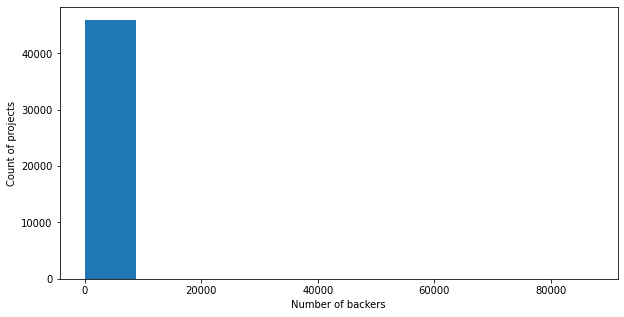

In [16]:
plt.hist(df['backers'])
plt.xlabel('Number of backers')
plt.ylabel('Count of projects')
plt.show()

The default chart isn't too clear, with most projects getting very few backers. Let's check how many projects got no backers

In [17]:
df.groupby('backers').size()

backers
0        3945
1        2566
2        1924
3        1456
4        1139
         ... 
24883       1
36276       1
61290       1
68929       1
87142       1
Length: 974, dtype: int64

It's pretty clear from this, and the describe() that there's a huge variation in backers, but it confirms the vast majority have very few backing. So let's try binning the data to get a more detailed chart.


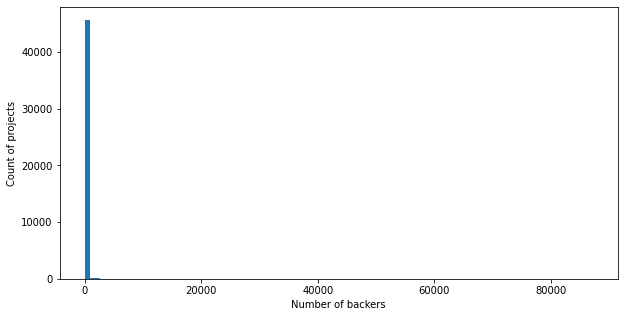

In [18]:
plt.hist(df['backers'], bins=100);
plt.xlabel('Number of backers')
plt.ylabel('Count of projects')
plt.show()

Not much better. Let's explore why. The standard deviation for backers is 688.628479, with an enormous range. So let's try this again by removing the outliers. 


/tmp/ipykernel_483/3611878041.py:24: FutureWarning: Support for multi-dimensional indexing (e.g. `obj[:, None]`) is deprecated and will be removed in a future version.  Convert to a numpy array before indexing instead.
  points = points[:,None]


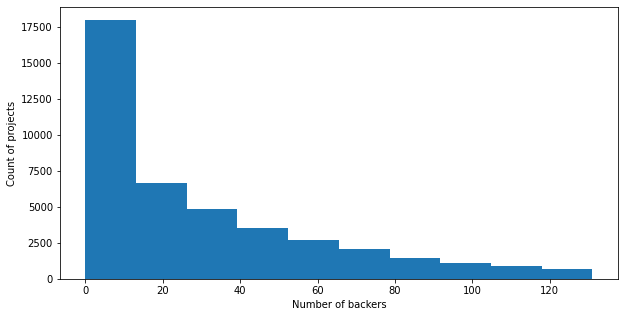

In [19]:
backers = df['backers']
filtered_backers = backers[~is_outlier(backers)] # drops with a z-score of > 3.5 on both ends
plt.hist(filtered_backers)
plt.xlabel('Number of backers')
plt.ylabel('Count of projects')
plt.show()


So we can conclude that the data is *right-skewed*, and the mean isn't going to be giving us a good estimate of the data. 

3. Is the ‘duration’ variable normally distributed? *

Let's plot what a normal distribution looks like (borrowed from here: https://www.geeksforgeeks.org/how-to-plot-normal-distribution-over-histogram-in-python/)

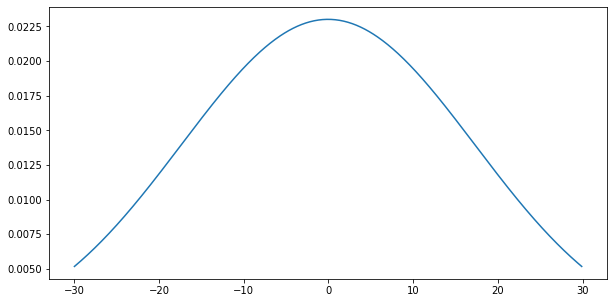

In [20]:
# Plot between -30 and 30 with
# 0.1 steps.
x_axis = np.arange(-30, 30, 0.1)
    
# Calculating mean and standard 
# deviation
mean = statistics.mean(x_axis)
sd = statistics.stdev(x_axis)
    
plt.plot(x_axis, norm.pdf(x_axis, mean, sd))
plt.show()

Then we can plot what the distribution of duration looks like. It certainly doesn't *look* like it conforms to normal distribution.

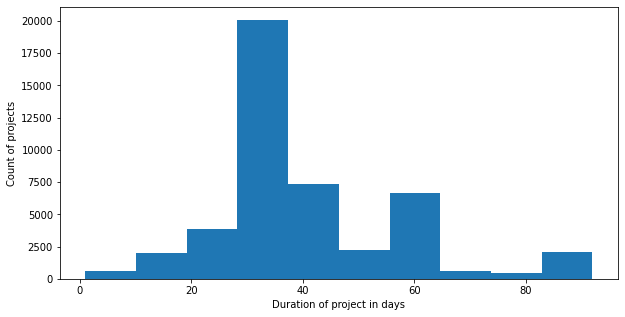

In [21]:
plt.hist(df['duration'])
plt.xlabel('Duration of project in days')
plt.ylabel('Count of projects')
plt.show()

Let's overlay them and check

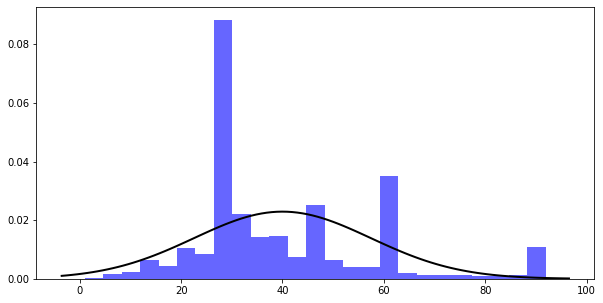

In [22]:
# Let's fit a distribution to the data
mu, std = norm.fit(df['duration'])

# Plot the histogram of our data again
plt.hist(df['duration'], bins=25, density=True, alpha=0.6, color='b')

# Plot the probability density function
xmin, xmax = plt.xlim()
x = np.linspace(xmin, xmax, 100)
p = norm.pdf(x, mu, std)
  
plt.plot(x, p, 'k', linewidth=2)

plt.show()

So, no, the distribution is *not* normal. We could develop this further, and develop a mathematical analysis to confirm once-and-for-all that it is not normal.

# Part 2 questions

1. What's the best length of time to run a campaign?

Let's group the Kickstarters together by how many days they ran for

In [75]:
df['duration_rounded'] = df['duration'].round()
duration_grouped = df.groupby('duration_rounded').agg({'funded_percentage':'mean'}).round(decimals=1).reset_index()
duration_grouped.head(10)

,duration_rounded,funded_percentage
0,1.0,8.0
1,2.0,2.5
2,3.0,1.1
3,4.0,1.0
4,5.0,1.0
5,6.0,0.8
6,7.0,1.1
7,8.0,5.0
8,9.0,153.2
9,10.0,2.2


It's pretty clear we have some outliers in the funding percentages, so let's trim the data, and re-run the group by.

In [83]:
df_nodurationoutliers = df[~is_outlier(df['funded_percentage'])]
duration_grouped = df_nodurationoutliers.groupby('duration_rounded').agg({'funded_percentage':'mean'}).round(decimals=1).reset_index()
duration_grouped.head(20)

/tmp/ipykernel_483/3611878041.py:24: FutureWarning: Support for multi-dimensional indexing (e.g. `obj[:, None]`) is deprecated and will be removed in a future version.  Convert to a numpy array before indexing instead.
  points = points[:,None]


,duration_rounded,funded_percentage
0,1.0,1.0
1,2.0,0.9
2,3.0,0.8
3,4.0,1.0
4,5.0,0.9
5,6.0,0.8
6,7.0,1.0
7,8.0,0.9
8,9.0,0.9
9,10.0,1.0


Now, let's average out the funding percentage on each of those days.

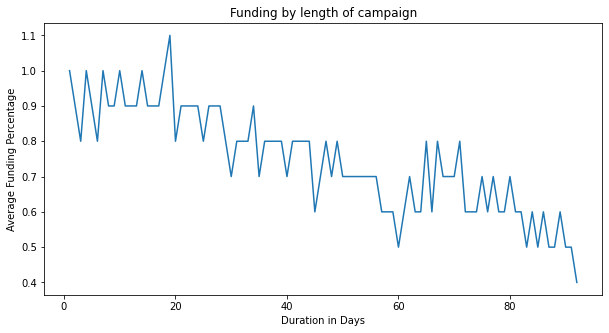

In [91]:
#x = duration_grouped.index.values
#y = duration_grouped['funded_percentage']

#s = sns.catplot(y='duration_rounded', x='funded_percentage', data=duration_grouped, kind='bar', height=10, aspect=1, orient = 'h')
sns.lineplot(y='funded_percentage', x='duration_rounded', data=duration_grouped)
plt.xlabel('Duration in Days')
plt.ylabel('Average Funding Percentage')
plt.title('Funding by length of campaign')
plt.show()

In [ ]:
It certainly seems that there is a sweet spot of around 20 days that generates an average funding percentage over 100%.

2. What's the ideal pledge goal?

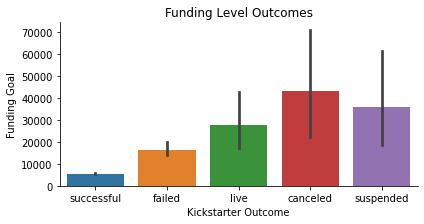

In [96]:
# Borrowing from here: https://www.geeksforgeeks.org/plotting-different-types-of-plots-using-factor-plot-in-seaborn/
# Plot showing rates of success by duration, with a confidence indicator
sns.catplot(x='status', y='goal', kind='bar', data=df, height=3, aspect=2)
plt.xlabel('Kickstarter Outcome')
plt.ylabel('Funding Goal')
plt.title('Funding Level Outcomes')
plt.show()

That's very interesting. Successful projects seem to have small goals, and little variation in that goal. Let's do some of the standard deviation of the goal amounts to confirm that's the case.

In [26]:
onlysuccess = df[df['status'] == 'successful']
np.std(onlysuccess['goal'])

12363.78116116044

In [27]:
np.std(df['goal'])

188756.24941071382

So comparing the standard deviation of only the successful projects vs. the full data set, we can see there's significantly lower variation. 

In [28]:
np.mean(onlysuccess['goal'])

5483.827983368888

So we could say the ideal funding goal is just $5,483. But let's take it a bit further: what happens to those projects once they hit their funding goals.

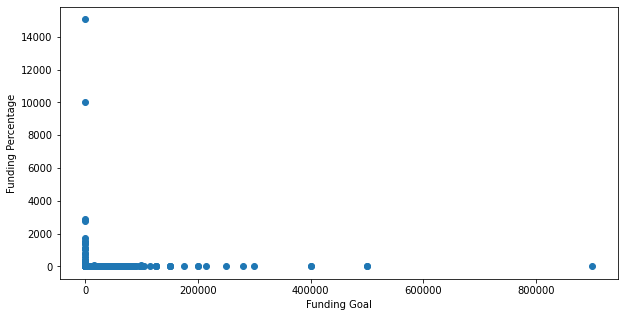

In [29]:
x = onlysuccess['goal']
y = onlysuccess['funded_percentage']

plt.scatter(x,y)
plt.xlabel('Funding Goal')
plt.ylabel('Funding Percentage')
plt.show()

We've obviously got some outliers here that are obscuring the data. Let's trim them off, and take another look.

/tmp/ipykernel_483/3611878041.py:24: FutureWarning: Support for multi-dimensional indexing (e.g. `obj[:, None]`) is deprecated and will be removed in a future version.  Convert to a numpy array before indexing instead.
  points = points[:,None]


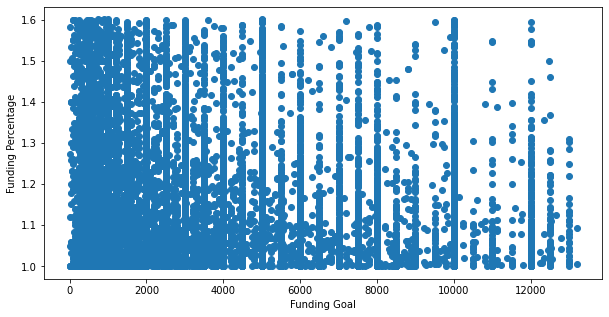

In [30]:
filtered_success = onlysuccess[~is_outlier(onlysuccess['funded_percentage'])]
filtered_success = filtered_success[~is_outlier(filtered_success['goal'])]

x = filtered_success['goal']
y = filtered_success['funded_percentage']

plt.scatter(x,y)
plt.xlabel('Funding Goal')
plt.ylabel('Funding Percentage')
plt.show()

There's definitely something worth exploring more here, but the trend certainly seems to be that projects below $8,000 have the highest chance of success, and the highest chance of getting significantly above their funding goal.

3. What type of projects would be most successful at getting funded?

Let's see what kinds of projects we have

In [31]:
df['category'].unique()




array(['Film & Video', 'Games', 'Fashion', 'Music', 'Art', 'Technology',
       'Dance', 'Publishing', 'Theater', 'Comics', 'Design',
       'Photography', 'Food', 'Film &amp; Video'], dtype=object)

A small bit of cleaning up to do, so let's swap that escaped coding to something a bit cleaner.

In [32]:
df['category'] = df['category'].str.replace('&amp;','&')
df['category'].unique().tolist()

['Film & Video',
 'Games',
 'Fashion',
 'Music',
 'Art',
 'Technology',
 'Dance',
 'Publishing',
 'Theater',
 'Comics',
 'Design',
 'Photography',
 'Food']

Ok, let's extract some magic from the data, and see what the success/failure percentages were for each category.

In [33]:
# Pivot the data on category and status
category_grouped = df.groupby(['category', 'status']).agg({'name': 'count'})

# Calculate the data as a percentage of its peers 
category_grouped_percents = category_grouped.groupby(level=0).apply(lambda x: 100 * x / float(x.sum())).reset_index()

# Let's see it
print(category_grouped_percents)

        category      status       name
0            Art      failed  39.704409
1            Art        live   7.540080
2            Art  successful  52.755511
3         Comics      failed  41.791045
4         Comics        live   9.701493
5         Comics  successful  48.507463
6          Dance      failed  23.653088
7          Dance        live   7.095926
8          Dance  successful  69.250986
9         Design    canceled   0.113122
10        Design      failed  47.341629
11        Design        live  11.199095
12        Design  successful  41.233032
13        Design   suspended   0.113122
14       Fashion      failed  60.211268
15       Fashion        live  10.299296
16       Fashion  successful  29.489437
17  Film & Video    canceled   0.169729
18  Film & Video      failed  45.546454
19  Film & Video        live   6.877721
20  Film & Video  successful  47.398716
21  Film & Video   suspended   0.007380
22          Food    canceled   0.208478
23          Food      failed  44.683808


And now make it into a chart...

/home/henry/Data/Kickstarter/kickstarter-data/lib/python3.8/site-packages/seaborn/categorical.py:3717: UserWarning: The `factorplot` function has been renamed to `catplot`. The original name will be removed in a future release. Please update your code. Note that the default `kind` in `factorplot` (`'point'`) has changed `'strip'` in `catplot`.
  warnings.warn(msg)


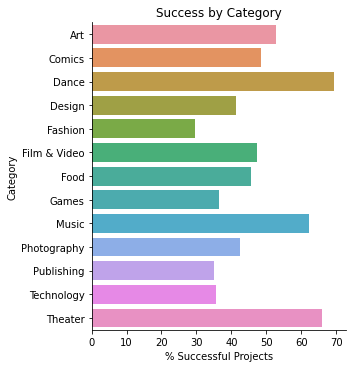

In [34]:
# Bar charts!
category_grouped_percents_successonly = category_grouped_percents[category_grouped_percents['status']=='successful']

sns.factorplot(y='category', x='name', data=category_grouped_percents_successonly, kind='bar')
plt.xlabel('% Successful Projects')
plt.ylabel('Category')
plt.title('Success by Category')
plt.show()

It's pretty clear that the standout projects are Dance, Music and Theatre. But how many were they of the total? Let's quickly look back at the categories.

In [35]:
df.groupby(['category']).agg({'name': 'count'})

,name
category,
Art,3992
Comics,1072
Dance,761
Design,1768
Fashion,1136
Film & Video,13551
Food,1439
Games,1738
Music,10913


Dance is just a fraction of the projects in this dataset, but the many Music and Theater projects certainly have a high chance of success.

4. Is there an ideal month/day/time to launch a campaign?

When we looked at the data back at the start, we could see the date & time is a single field. 

_One thing to note is that_ -- without a data dictionary -- we don't know what "funded_date" represents. If it's actually the *end* of the funding period, we would need to subtract the 'duration' field from the funded_date field, to get the accurate state date. 

However, we can see that it is Zulu time (GMT), so let's convert that to US Pacific time first. Then let's split it out into month, day of the week, time of day. 

In [36]:
# convert the datetime to be US Pacific
df['funded_date'] = pd.DatetimeIndex(df['funded_date']).tz_convert('US/Pacific')

# extract the individual components of the datetime
df['funded_date_month'] = pd.DatetimeIndex(df['funded_date']).month_name()
df['funded_date_dayofweek'] = pd.DatetimeIndex(df['funded_date']).day_name()
df['funded_date_hour'] = pd.DatetimeIndex(df['funded_date']).hour

# and check the results
df.head(10)


,project_id,name,url,category,subcategory,location,status,goal,pledged,funded_percentage,...,funded_date,levels,reward_levels,updates,comments,duration,duration_rounded,funded_date_month,funded_date_dayofweek,funded_date_hour
0,39409,WHILE THE TREES SLEEP,http://www.kickstarter.com/projects/emiliesaba...,Film & Video,Short Film,"Columbia, MO",successful,10500.0,11545.0,1.099524,...,2011-08-19 12:28:17-07:00,7,"$25,$50,$100,$250,$500,$1,000,$2,500",10,2,30.00,30.0,August,Friday,12
1,126581,Educational Online Trading Card Game,http://www.kickstarter.com/projects/972789543/...,Games,Board & Card Games,"Maplewood, NJ",failed,4000.0,20.0,0.005000,...,2010-08-01 20:59:00-07:00,5,"$1,$5,$10,$25,$50",6,0,47.18,47.0,August,Sunday,20
2,138119,STRUM,http://www.kickstarter.com/projects/185476022/...,Film & Video,Animation,"Los Angeles, CA",live,20000.0,56.0,0.002800,...,2012-06-07 17:00:31-07:00,10,"$1,$10,$25,$40,$50,$100,$250,$1,000,$1,337,$9,001",1,0,28.00,28.0,June,Thursday,17
3,237090,GETTING OVER - One son's search to finally kno...,http://www.kickstarter.com/projects/charnick/g...,Film & Video,Documentary,"Los Angeles, CA",successful,6000.0,6535.0,1.089167,...,2012-04-07 19:14:00-07:00,13,"$1,$10,$25,$30,$50,$75,$85,$100,$110,$250,$500...",4,0,32.22,32.0,April,Saturday,19
4,246101,The Launch of FlyeGrlRoyalty &quot;The New Nam...,http://www.kickstarter.com/projects/flyegrlroy...,Fashion,Fashion,"Novi, MI",failed,3500.0,0.0,0.000000,...,2011-06-01 08:25:39-07:00,6,"$10,$25,$50,$100,$150,$250",2,0,30.00,30.0,June,Wednesday,8
5,316217,Dinner Party - a short film about friendship.....,http://www.kickstarter.com/projects/249354515/...,Film & Video,Short Film,"Portland, OR",successful,3500.0,3582.0,1.023331,...,2011-06-22 06:33:00-07:00,7,"$5,$25,$50,$100,$250,$500,$1,000",8,0,21.43,21.0,June,Wednesday,6
6,325034,Mezzo,http://www.kickstarter.com/projects/geoffsaysh...,Film & Video,Short Film,"Collegedale, TN",failed,1000.0,280.0,0.280000,...,2012-02-17 18:17:08-08:00,5,"$5,$10,$25,$50,$100",0,0,30.00,30.0,February,Friday,18
7,407836,Help APORTA continue to make handwoven/knit ac...,http://www.kickstarter.com/projects/1078097864...,Fashion,Fashion,"Chicago, IL",successful,2000.0,2180.0,1.090000,...,2011-12-29 20:36:53-08:00,7,"$10,$20,$50,$100,$250,$500,$1,000",13,5,30.00,30.0,December,Thursday,20
8,436325,Music - Comedy - Album!,http://www.kickstarter.com/projects/mattgriffo...,Music,Music,"Chicago, IL",successful,1000.0,1125.0,1.125000,...,2010-04-17 21:59:00-07:00,12,"$5,$8,$10,$15,$20,$30,$50,$100,$120,$250,$500,...",10,1,67.53,68.0,April,Saturday,21
9,610918,The Apocalypse Calendar,http://www.kickstarter.com/projects/tqvinn/the...,Art,Illustration,"Chicago, IL",successful,7500.0,9836.0,1.311527,...,2011-10-31 21:59:00-07:00,10,"$1,$20,$35,$50,$60,$100,$110,$500,$1,000,$1,500",6,5,35.29,35.0,October,Monday,21


Now that we have the data successfully extract, we can do some computation on it (essentially repeating what we did with the category work)

/home/henry/Data/Kickstarter/kickstarter-data/lib/python3.8/site-packages/seaborn/categorical.py:3717: UserWarning: The `factorplot` function has been renamed to `catplot`. The original name will be removed in a future release. Please update your code. Note that the default `kind` in `factorplot` (`'point'`) has changed `'strip'` in `catplot`.
  warnings.warn(msg)


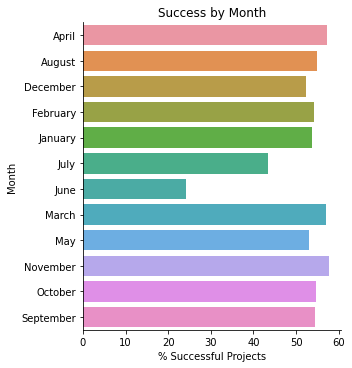

In [37]:
# Pivot the data on month and status
month_grouped = df.groupby(['funded_date_month', 'status']).agg({'name': 'count'})

# Calculate the data as a percentage of its peers 
month_grouped_percents = month_grouped.groupby(level=0).apply(lambda x: 100 * x / float(x.sum())).reset_index()

# Filter to successful projects only
month_grouped_percents_successonly = month_grouped_percents[month_grouped_percents['status']=='successful']

# And plot it!
sns.factorplot(y='funded_date_month', x='name', data=month_grouped_percents_successonly, kind='bar')
plt.xlabel('% Successful Projects')
plt.ylabel('Month')
plt.title('Success by Month')
plt.show()

/home/henry/Data/Kickstarter/kickstarter-data/lib/python3.8/site-packages/seaborn/categorical.py:3717: UserWarning: The `factorplot` function has been renamed to `catplot`. The original name will be removed in a future release. Please update your code. Note that the default `kind` in `factorplot` (`'point'`) has changed `'strip'` in `catplot`.
  warnings.warn(msg)


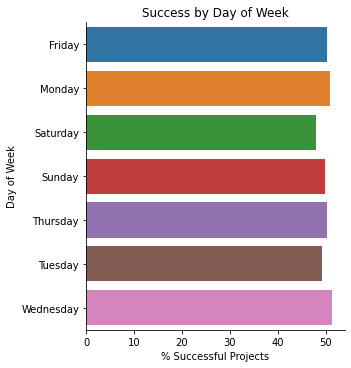

In [38]:
# Pivot the data on day of week and status
dayofweek_grouped = df.groupby(['funded_date_dayofweek', 'status']).agg({'name': 'count'})

# Calculate the data as a percentage of its peers 
dayofweek_grouped_percents = dayofweek_grouped.groupby(level=0).apply(lambda x: 100 * x / float(x.sum())).reset_index()

# Filter to successful projects only
dayofweek_grouped_percents_successonly = dayofweek_grouped_percents[dayofweek_grouped_percents['status']=='successful']

# And plot it!
sns.factorplot(y='funded_date_dayofweek', x='name', data=dayofweek_grouped_percents_successonly, kind='bar')
plt.xlabel('% Successful Projects')
plt.ylabel('Day of Week')
plt.title('Success by Day of Week')
plt.show()

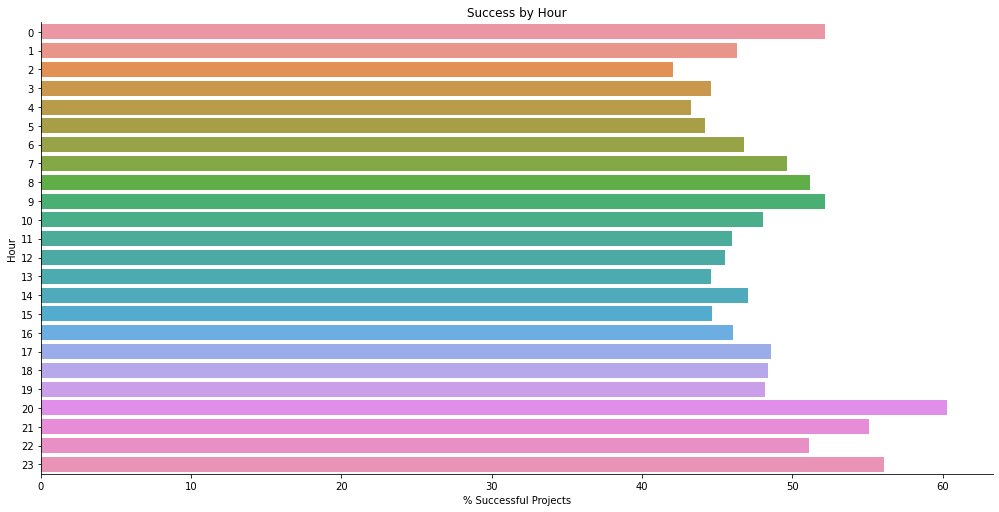

In [98]:
# Pivot the data on hour and status
hour_grouped = df.groupby(['funded_date_hour', 'status']).agg({'name': 'count'})

# Calculate the data as a percentage of its peers 
hour_grouped_percents = hour_grouped.groupby(level=0).apply(lambda x: 100 * x / float(x.sum())).reset_index()

# Filter to successful projects only
hour_grouped_percents_successonly = hour_grouped_percents[hour_grouped_percents['status']=='successful']

# And plot it!
sns.catplot(y='funded_date_hour', x='name', data=hour_grouped_percents_successonly, kind='bar', orient = 'h', height=7, aspect=2)
plt.xlabel('% Successful Projects')
plt.ylabel('Hour')
plt.title('Success by Hour')
plt.show()

As long as you avoid the summer months and launch your project late in the evening or at the start of the day, your project will have a higher chance of being successful. If you really want to have a little extra luck, do it on a Monday!